Colab link: https://colab.research.google.com/drive/1DIcOGTOpNfef4UrJiwXDPBKA0KHDRfrN?usp=sharing.

# CIFAR-10 dataset

In this notebook, we use the CIFAR-10 dataset made of images from 10 classes: plane, car, bird, cat, deer, dog, frog, horse, ship, and truck. The images are all of the same size with $3\times 32\times 32$ pixels. The first channel is used for the RGB description of the image with the 2 others are the X and Y position of a pixel.

1. What is the machine learning family this problem is about? What is the nature of the input data?

2. Enumerate some methods that could be used for such a task.

# Prerequisites

3. Import the necessary packages. In particular, we will use:
> * [`matplotlib`](https://matplotlib.org/) for data visualisation and plots,
> * [`numpy`](https://numpy.org/) for standard numerical operations and algebra,
> * [`pyTorch`](https://pytorch.org/) for deep learning models and related functions used for model selection or data pre-processing.

In [ ]:
import matplotlib.pyplot as plt     # For plotting
import matplotlib as mpl            # For plotting setup
import numpy as np                  # For numerical calculations

# All the torch-related libraries
import torch                  # Generic torch path
import torchvision            # Contains some datasets and utilities functions
from torch import nn          # To build neural networks
import torch.optim as optim   # Optimization functions
import torchvision.transforms as transforms   # For the PIL to tensor format
from torch.utils.data.sampler import SubsetRandomSampler # For validation set

# Formatting the plots
plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'normal'
plt.style.use('default')
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.formatter.limits'] = (-6, 6)
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

# Function to print the accuracy of our model on the different classes
def print_acc(model, testloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # No gradients needed
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Download the data
transform = transforms.Compose(
    [transforms.ToTensor(), # PIL image to tensor
     transforms.Normalize((0.4912, 0.4829, 0.4479), (0.2470, 0.2435, 0.2616))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# # To compute normalization
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset),
#                                            shuffle=True, num_workers=2)
# data = next(iter(trainloader))[0]
# mean = data.mean(axis=(0, 2, 3))
# std = data.std(axis=(0, 2, 3))
# print(mean, std)

tensor([ 0.0008, -0.0030, -0.0052]) tensor([1.0001, 0.9999, 1.0000])


To access the images, you can use the `trainset.data` command returning the set of all images. For the class, use `trainset.targets` which returns the list containing the class of all the images in the same order as in the data.

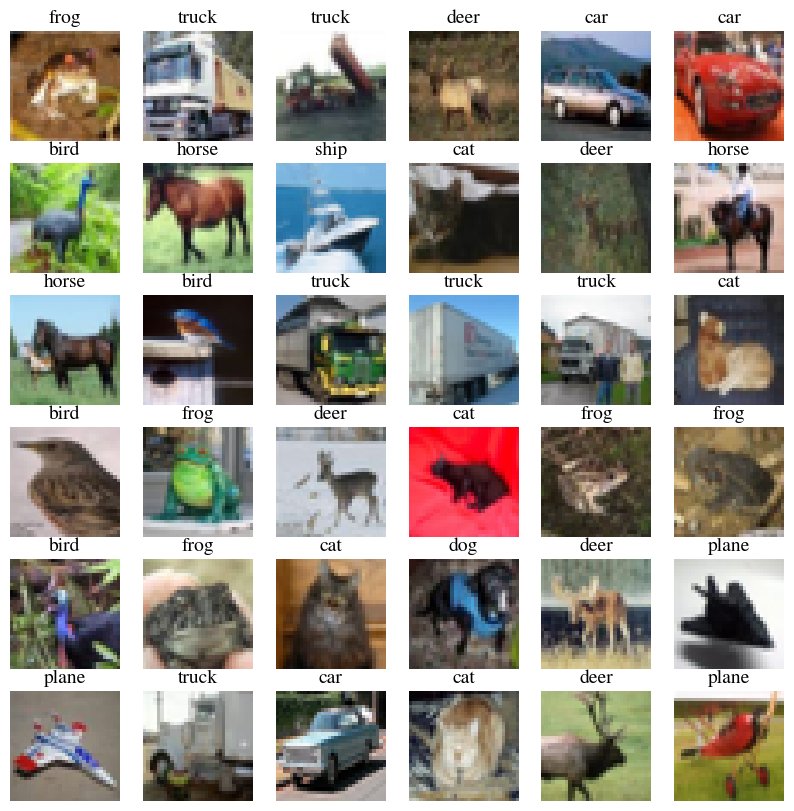

In [ ]:
# Plot some images
nx = 6
ny = 6
fig, ax = plt.subplots(nx, ny, figsize=(10,10))
for i in range(nx):
  for j in range(ny):
    ax[i][j].imshow(trainset.data[i*nx+j])
    ax[i][j].axis('off')
    ax[i][j].set_title(classes[trainset.targets[i*nx+j]],
                       fontsize=14)

4. How many images are there in both the train and test datasets?

In [ ]:
print(trainset.data.shape)
print(testset.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


5. What are the proportions of images in each class in the two datasets (train and test)
?

[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Text(0.5, 1.0, 'Proportion test set')

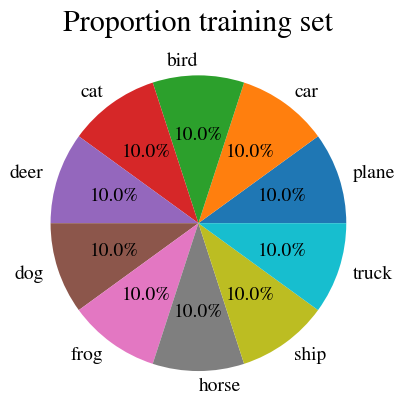

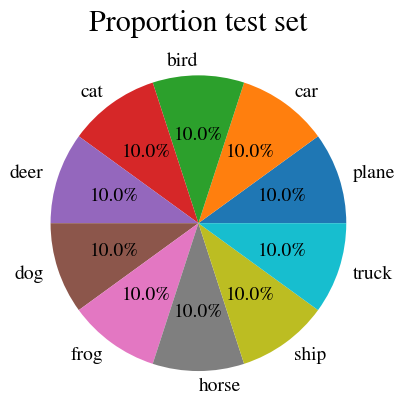

In [ ]:
# Proportion training set
_, counts_train = np.unique(trainset.targets, return_counts=True)

print(counts_train)
fig, ax = plt.subplots()
_ = ax.pie(counts_train, labels=classes, autopct='%1.1f%%', textprops={'fontsize': 14})
ax.set_title(r'Proportion training set')

# Proportion test set
_, counts_test = np.unique(testset.targets, return_counts=True)

print(counts_test)
fig, ax = plt.subplots()
_ = ax.pie(counts_test, labels=classes, autopct='%1.1f%%', textprops={'fontsize': 14})
ax.set_title(r'Proportion test set')

# Feed-forward neural network

The first model we'll build is a feed-forward neural network. The first step when building a neural network model in PyTorch is to setup the data into an iterable object, called a [DataLoader](https://pytorch.org/docs/stable/data.html). It also allows to shuffle the data based on a given batch size.

6. Remind:
  1) what are the use of train/validation/test sets,
  2) what is a batch size and what is it used for in optimization.

In [ ]:
BATCH_SIZE = 64         # Size of the batches
SIZE_IN = (3, 32, 32)   # Size of one input image
SIZE_OUT = 10           # Number of classes

# Split the data into train/validation
valid_size = 0.2
n_train = len(trainset.data)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * n_train))

train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
    sampler=train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(trainset, batch_size=len(valid_idx),
    sampler=valid_sampler, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset.data),
    num_workers=2)

In PyTorch, a model can be specified as a sequence of several layers. All the possible layers proposed by PyTorch are listed [here](https://pytorch.org/docs/stable/nn.html#linear-layers).

To implement a new model, one needs to create a subclass of `torch.nn.Module` and specify in a first function `__init__(self):` the layers with their input and output sizes. Those layers will be used in a second function `forward(self, x)` taking as argument the model and a data $x$ (here an image for us).

7. Specify a network with 3 hidden layers. The first layer has 300 neurons, the second has 100 neurons, and the last has 10 neurons. They all have ReLU activation. The final layer will be of size 10 (number of classes) with no activation function. To help you, you can draw the diagram of this neural network.

To help you, you can also have a look at [this link](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

In [ ]:
# Fully-connected network
class FCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(np.prod(SIZE_IN), 300)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(300, 100)
        self.act2 = nn.ReLU()
        self.linear3 = nn.Linear(100, 50)
        self.act3 = nn.ReLU()
        self.linear4 = nn.Linear(50, SIZE_OUT)

    def forward(self, x):
        # First flatten the data
        out = x.view(x.size(0), -1)
        # Then apply the layers successively
        out = self.linear1(out)
        out = self.act1(out)
        out = self.linear2(out)
        out = self.act2(out)
        out = self.linear3(out)
        out = self.act3(out)
        out = self.linear4(out)
        return out

neural_net = FCNN() # Create an instance of an FCNN
print(neural_net)

FCNN(
  (linear1): Linear(in_features=3072, out_features=300, bias=True)
  (act1): ReLU()
  (linear2): Linear(in_features=300, out_features=100, bias=True)
  (act2): ReLU()
  (linear3): Linear(in_features=100, out_features=50, bias=True)
  (act3): ReLU()
  (linear4): Linear(in_features=50, out_features=10, bias=True)
)


8. How many parameters does this network have?

In [ ]:
n_param_tot = 0
for parameter in neural_net.parameters():
  n_param_tot += np.prod(parameter.shape)

print(n_param_tot)
print(3072*300 + 300 + 300*100 + 100 + 100*50 + 50 + 10*50 + 10)

957560
957560


Now our model is fully specified, we have all the parameters.
To train our neural network with the data at hand, we use the backpropagation algorithm and the stochastic gradient descent method.

9. Remind how stochastic gradient descent works.

10. Specify a loss function and an optimization procedure. In our case, we'll use the [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) together with the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html). Set the learning rate to 0.02.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()  # Cross entropy loss function
optimizer = torch.optim.SGD(neural_net.parameters(), lr=0.02)

11. Train the neural network for 10 epochs.
To compute and update the gradient, there are four steps:
> * First compute the loss on the batch,
> * Clean your optimizer using the [`optimizer.zero_grad()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html) function,
> * Call the [`backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) function of the loss to compute the gradient,
> * Make a step in the opposite gradient direction using the [`optimizer.step()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html) function.

Make sure to save the train and validation loss functions to vizualize it afterwards.

In [ ]:
# Number of batches in total
n_batches = int(len(trainset) / BATCH_SIZE)
print('Total number of batches = {:d}'.format(n_batches))

N_EPOCHS = 10
train_loss = []
valid_loss = []
X_valid, y_valid = next(iter(validloader))

# Loop for a fixed number of epochs
for epoch in range(N_EPOCHS):

    # Training part
    neural_net.train()                    # Set my model in training mode
    total_loss = 0
    for (X_batch, y_batch) in trainloader:
        y_pred = neural_net(X_batch)      # Prediction of my model on the batch of data
        loss = loss_fn(y_pred, y_batch)   # Compute the loss on the batch
        optimizer.zero_grad()             # Set the gradient to zero before backprop
        loss.backward()                   # Perform backpropagation
        optimizer.step()                  # Take one step in the opposite gradient direction
        total_loss += loss.item() / n_batches
    train_loss.append(total_loss)

    # Evaluation part after one batch
    neural_net.eval()                     # Set my model in evaluation mode
    out = neural_net(X_valid)                          # Generate predictions
    loss = nn.functional.cross_entropy(out, y_valid)   # Calculate loss
    _, preds = torch.max(out, dim=1)
    acc = (preds == y_valid).float().mean()
    print("Epoch %d: train loss = %.2f, validation loss = %.2f, validation accuracy = %.2f%%" % (epoch, total_loss, loss.item(), acc*100))
    valid_loss.append(loss.item())

Total number of batches = 781
Epoch 0: train loss = 1.59, test loss = 1.74, validation accuracy = 38.61%
Epoch 1: train loss = 1.32, test loss = 1.59, validation accuracy = 44.13%
Epoch 2: train loss = 1.21, test loss = 1.50, validation accuracy = 47.47%
Epoch 3: train loss = 1.14, test loss = 1.44, validation accuracy = 49.77%
Epoch 4: train loss = 1.08, test loss = 1.42, validation accuracy = 50.86%
Epoch 5: train loss = 1.03, test loss = 1.44, validation accuracy = 49.96%
Epoch 6: train loss = 0.99, test loss = 1.37, validation accuracy = 52.52%
Epoch 7: train loss = 0.95, test loss = 1.38, validation accuracy = 52.29%
Epoch 8: train loss = 0.91, test loss = 1.37, validation accuracy = 52.87%
Epoch 9: train loss = 0.87, test loss = 1.38, validation accuracy = 52.73%


12. Have a look at the evolution of the test and training losses over the epochs. Do you see any sign of generalisation issue? If any, how could we solve them?

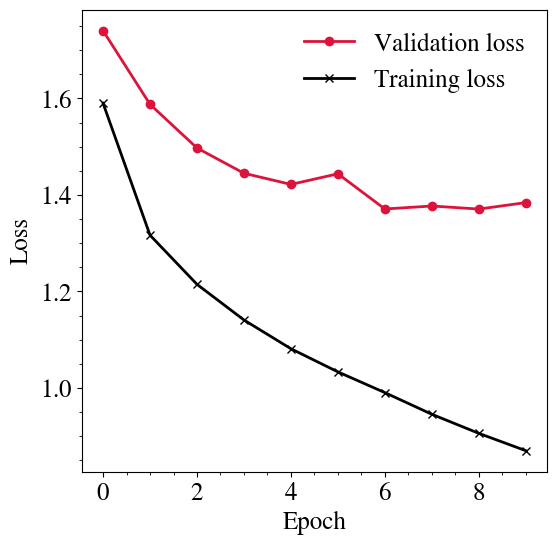

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(valid_loss, '-o', color='crimson', lw=2, label=r'Validation loss')
ax.plot(train_loss, '-x', color='k', lw=2, label=r'Training loss')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.legend(frameon=False)

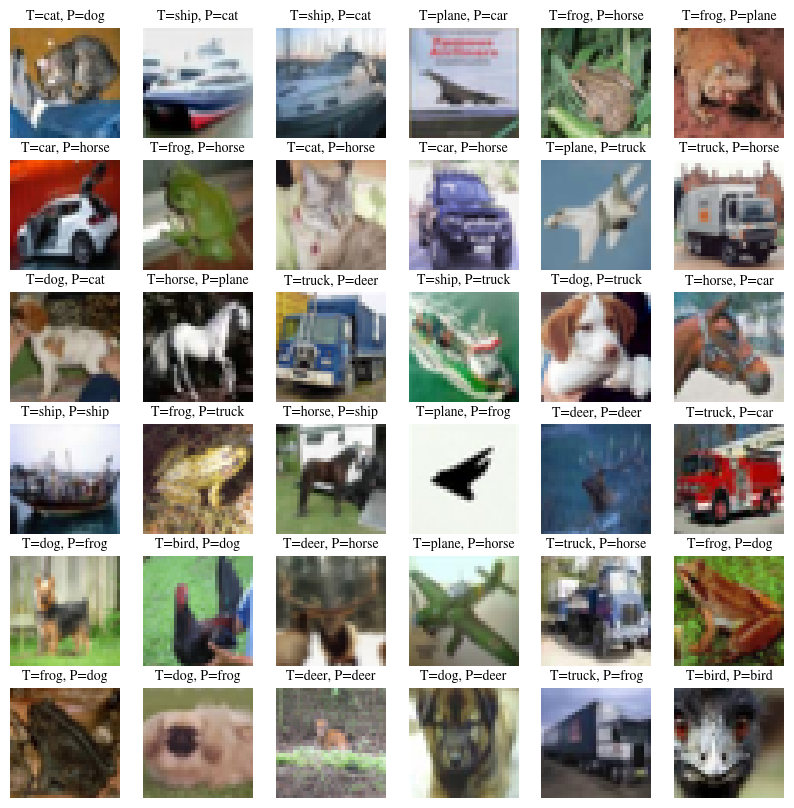

In [ ]:
# Plot some images of the test set and their classification
nx = 6
ny = 6
fig, ax = plt.subplots(nx, ny, figsize=(10,10))
for i in range(nx):
  for j in range(ny):
    ax[i][j].imshow(testset.data[i*nx+j])
    ax[i][j].axis('off')
    ax[i][j].set_title('T={:s}, P={:s}'.format(
        classes[testset.targets[i*nx+j]],
        classes[preds[i*nx+j]]), fontsize=10)

In [ ]:
print_acc(neural_net, validloader, classes)

Accuracy for class: plane is 58.6 %
Accuracy for class: car   is 56.4 %
Accuracy for class: bird  is 42.2 %
Accuracy for class: cat   is 31.8 %
Accuracy for class: deer  is 49.5 %
Accuracy for class: dog   is 42.1 %
Accuracy for class: frog  is 61.1 %
Accuracy for class: horse is 65.5 %
Accuracy for class: ship  is 67.1 %
Accuracy for class: truck is 53.6 %


# Convolutional neural network

Let us now build another model that is acknowledged to be better suited for the handling of images by incorporating some (local) invariances to translation and deformations: the Convolutional Neural Network.

13. Remind the key building blocks of a CNN and what they do mathematically.

The model we will build is based on the original application of the CNN proposed by [Lecun+98](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) (see Fig. 2).
Our network is made of:
- One convolutional layer with 6 filters of size 5x5 and a padding of 2 and ReLU activation,
- One average pooling with kernel size 2,
- One convolutional layer with 16 filters of size 5x5 and ReLU activation,
- One average pooling with kernel size 2,
- One convolutional layer with 120 filters of size 5x5 and ReLU activation,
- A fully-connected layer with 84 neurons and a ReLU activation,
- A fully-connected layer with 10 neurons to predict the class (with no activation).

14. Implement this network using the layers from the [torch.nn](https://pytorch.org/docs/stable/nn.html) module as above.

In [ ]:
# @title
class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, kernel_size=5, padding=2)
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)

        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5, padding=0)
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)

        self.conv3 = torch.nn.Conv2d(16, 120, kernel_size=5, padding=0)
        self.act3 = torch.nn.ReLU()

        self.flat = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(2*2*120, 84)
        self.act4 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Input is 3x32x32   Output is 6x32x32
        out = self.act1(self.conv1(x))
        # Input is 6x32x32   Output is 6x16x16
        out = self.pool1(out)
        # Input is 6x16x16   Output is 16x12x12
        out = self.act2(self.conv2(out))
        # Input is 16x12x12   Output is 16x6x6
        out = self.pool2(out)
        # Input is 16x6x6   Output is 120x2x2
        out = self.act3(self.conv3(out))
        # Input is 120x2x2   Output is 84
        out = self.act4(self.fc1(self.flat(out)))
        # Input is 84   Output is 10
        out = self.fc2(out)
        return out

CNN = LeNet5()
print(CNN)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (act3): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=480, out_features=84, bias=True)
  (act4): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


15. How many parameters this network has? (At least numerically). Comment.

In [ ]:
n_param_tot = 0
for parameter in CNN.parameters():
  n_param_tot += np.prod(parameter.shape)

print(n_param_tot)

92246


Let's train it and see how it performs!

16. Train the CNN using the cross entropy loss and SGD optimizer as before.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()  # Cross entropy loss function
optimizer =  torch.optim.SGD(CNN.parameters(), lr=0.02)

N_EPOCHS = 20
test_loss_CNN = []
train_loss_CNN = []
X_test, y_test = next(iter(testloader))

for epoch in range(N_EPOCHS):

    # Training part
    CNN.train()                    # Set my model in training mode
    total_loss = 0
    for (X_batch, y_batch) in trainloader:
        y_pred = CNN(X_batch)      # Prediction of my model on the batch of data
        loss = loss_fn(y_pred, y_batch)   # Compute the loss on the batch
        optimizer.zero_grad()             # Set the gradient to zero before backprop
        loss.backward()                   # Perform backpropagation
        optimizer.step()                  # Take one step in the opposite gradient direction
        total_loss += loss.item() / n_batches
    train_loss_CNN.append(total_loss)

    # Evaluation part after one batch
    CNN.eval()                     # Set my model in evaluation mode
    out = CNN(X_test)              # Generate predictions
    loss = nn.functional.cross_entropy(out, y_test)   # Calculate loss
    _, preds_CNN = torch.max(out, dim=1)
    acc = (preds_CNN == y_test).float().mean()
    print("Epoch %d: train loss = %.2f, test loss = %.2f, test accuracy = %.2f%%" % (epoch, total_loss, loss.item(), acc*100))
    test_loss_CNN.append(loss.item())

Epoch 0: train loss = 1.67, test loss = 1.81, test accuracy = 34.10%
Epoch 1: train loss = 1.35, test loss = 1.56, test accuracy = 43.64%
Epoch 2: train loss = 1.22, test loss = 1.49, test accuracy = 46.78%
Epoch 3: train loss = 1.14, test loss = 1.37, test accuracy = 51.43%
Epoch 4: train loss = 1.07, test loss = 1.39, test accuracy = 50.21%
Epoch 5: train loss = 1.01, test loss = 1.35, test accuracy = 51.22%
Epoch 6: train loss = 0.95, test loss = 1.20, test accuracy = 57.76%
Epoch 7: train loss = 0.91, test loss = 1.29, test accuracy = 54.79%
Epoch 8: train loss = 0.86, test loss = 1.14, test accuracy = 59.93%
Epoch 9: train loss = 0.82, test loss = 1.14, test accuracy = 60.30%
Epoch 10: train loss = 0.78, test loss = 1.13, test accuracy = 60.86%
Epoch 11: train loss = 0.75, test loss = 1.13, test accuracy = 61.19%
Epoch 12: train loss = 0.72, test loss = 1.17, test accuracy = 59.75%
Epoch 13: train loss = 0.69, test loss = 1.15, test accuracy = 61.25%
Epoch 14: train loss = 0.66, t

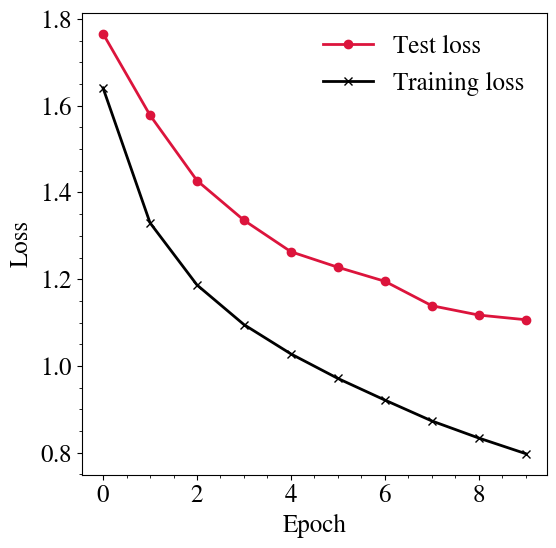

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(test_loss_CNN, '-o', color='crimson', lw=2, label=r'Test loss')
ax.plot(train_loss_CNN, '-x', color='k', lw=2, label=r'Training loss')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.legend(frameon=False)

In [ ]:
print('FCNN accuracy:')
print_acc(neural_net, testloader, classes)
print('')
print('CNN accuracy:')
print_acc(CNN, testloader, classes)

FCNN accuracy:
Accuracy for class: plane is 64.4 %
Accuracy for class: car   is 65.4 %
Accuracy for class: bird  is 39.8 %
Accuracy for class: cat   is 45.4 %
Accuracy for class: deer  is 46.5 %
Accuracy for class: dog   is 31.8 %
Accuracy for class: frog  is 54.6 %
Accuracy for class: horse is 67.4 %
Accuracy for class: ship  is 62.8 %
Accuracy for class: truck is 54.1 %

CNN accuracy:
Accuracy for class: plane is 63.6 %
Accuracy for class: car   is 74.0 %
Accuracy for class: bird  is 35.5 %
Accuracy for class: cat   is 41.8 %
Accuracy for class: deer  is 52.5 %
Accuracy for class: dog   is 51.0 %
Accuracy for class: frog  is 73.8 %
Accuracy for class: horse is 73.2 %
Accuracy for class: ship  is 79.3 %
Accuracy for class: truck is 68.5 %


# Going further

Now you can use the validation set (NOT the test set) to finetune the hyperparameters and see how far you can go. According [this benchmark](https://paperswithcode.com/sota/image-classification-on-cifar-10), the current models dominating the leaderboard on vision data are vision transformers (ViT), [introduced here](https://arxiv.org/pdf/2010.11929.pdf). You could also try to implement this, but you also see that some CNNs are achieving more than 80% accuracy, which is already really good. Some tricks to perform better consist in adding dropout, momentum, learning rate scheduling, in addition to careful hyperparameter tuning.